In [30]:
from dotenv import load_dotenv
load_dotenv()

from langchain_community.llms import Replicate
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore

import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.callbacks import StreamingStdOutCallbackHandler

from IPython.display import Image, display

**Using meta-llama-3-70b-instruct model**

In [2]:
llm = Replicate(
    model = "meta/meta-llama-3-70b-instruct",
    model_kwargs = {"temperature": 0.75, "max_length": 500, "top_p": 1}
)

In [3]:
embeddings = HuggingFaceEmbeddings(model_name = "BAAI/bge-small-en-v1.5")

/home/pradyumnsrivast/miniforge3/envs/lang/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
vector_store = InMemoryVectorStore(embeddings)

**Scrapping data from a webpage using beautiful soup**

In [5]:
# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43130


In [6]:
type(docs[0])

langchain_core.documents.base.Document

In [7]:
docs[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}

In [8]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


In [9]:
print(len(docs[0].page_content))

43130


Our loaded document is over 43k characters which is too long to fit into the context window of many models. Even for those models that could fit the full post in their context window, models can struggle to find information in very long inputs.

**Chunking the Document**

RecursiveCharacterTextSplitter will recursively split the document using common separators like new lines until each chunk is the appropriate size. This is the recommended text splitter for generic text use cases.

In [10]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,  # chunk size (characters)
    chunk_overlap = 200,  # chunk overlap (characters)
    add_start_index = True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


In [11]:
all_splits[1].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 971}

In [12]:
all_splits[1].page_content

'Memory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utilizing short-term memory of the model to learn.\nLong-term memory: This provides the agent with the capability to retain and recall (infinite) information over extended periods, often by leveraging an external vector store and fast retrieval.\n\n\nTool use\n\nThe agent learns to call external APIs for extra information that is missing from the model weights (often hard to change after pre-training), including current information, code execution capability, access to proprietary information sources and more.'

In [13]:
all_splits[2].page_content

'Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'

**Indexing**

In [14]:
document_ids = vector_store.add_documents(documents = all_splits)

In [15]:
len(all_splits) # 66 chunks of document

66

In [16]:
len(document_ids) # Each chuck is stored in an index

66

In [17]:
document_ids[:5]

['97176b82-3977-4549-a0a6-82fac08d85e3',
 '761eee0c-b793-415f-bcbc-c09888441723',
 'da475821-87e3-4039-ad5f-a86dccfd06f6',
 '64a00ae9-b9ee-4960-99d5-e6d6edc4b328',
 '1335b028-a10f-4b3a-87cd-7bb37f20dba5']

**Retrieval and Generation**

In [18]:
prompt = hub.pull("rlm/rag-prompt") # default system prompt

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


We will use Langraph to tie together retrieval and generation -

1. The state of our application (controls data flow in the app)
2. The nodes of our application (i.e., application steps)
3. The "control flow" of our application (e.g., the ordering of the steps)

In [19]:
# STATE

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [20]:
# NODES

def retrieve(state: State):
    '''
        Runs a similarity search on the input question
    '''
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    '''
        Formats the retrieved context and original question into a prompt for the chat model
    '''
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response}

In [21]:
# CONTROL

# Tie our app into a single graph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

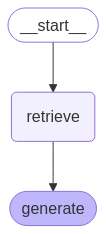

In [22]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
result = graph.invoke({"question": "What is Task Decomposition?"})

In [26]:
print(result['question'])

What is Task Decomposition?


In [27]:
print(result['context'])

[Document(id='da475821-87e3-4039-ad5f-a86dccfd06f6', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='64a00ae9-b9ee-4960-99d5-e6d6edc4b328', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by explori

In [28]:
len(result["context"])

4

In [29]:
print(f'Answer: {result["answer"]}')

Answer: 

Task decomposition is the process of breaking down a complex task into smaller, more manageable steps or subtasks. This can be achieved through various methods, including using language models with simple prompting, task-specific instructions, or human inputs. The goal of task decomposition is to make a big task more understandable and solvable by dividing it into simpler components.


**Stream Tokens**

In [33]:
llm = Replicate(
    streaming = True,
    callbacks = [StreamingStdOutCallbackHandler()],
    model="meta/meta-llama-3-8b-instruct",
    model_kwargs={"temperature": 0.75, "max_length": 500, "top_p": 1},
)
prompt = """
User: Answer the following yes/no question by reasoning step by step. Can humankind reach Jupiter in 2 days?
Assistant:
"""
ans = llm.invoke(prompt)



Let's break this down step by step!

1. Jupiter is approximately 778.3 million kilometers (483.8 million miles) away from Earth.
2. The fastest spacecraft ever built is NASA's Parker Solar Probe, which has a top speed of about 192,000 kilometers per hour (119,000 miles per hour).
3. To calculate how long it would take to reach Jupiter at this speed, we can use the formula: Distance / Speed = Time.

Plugging in the numbers, we get:

778,300,000 km / 192,000 km/h = approximately 4,040 hours

4. There are 24 hours in a day, so:

4,040 hours / 24 hours/day = approximately 168.3 days

5. Therefore, it would take the Parker Solar Probe, the fastest spacecraft ever built, about 168.3 days to reach Jupiter, not 2 days.

Conclusion: No, humankind cannot reach Jupiter in 2 days.